In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

Using TensorFlow backend.


VAE encoder network

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
# Dimensionality of the latent space: a 2D plane
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# The input image ends up being encoded into these two parameters.
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

 Latent-space-sampling function

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., 
                              stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

VAE decoder network, mapping latent space points to images

In [4]:
# Input where you’ll feed z
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsamples the input
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshapes z into a feature map of the same shape as the feature map 
# just before the last Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)

# Uses a Conv2DTranspose layer and Conv2D layer to decode z 
# into a feature map the same size as the original image input
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# Instantiates the decoder model, which turns “decoder_input” into the decoded image
decoder = Model(decoder_input, x)

# Applies it to z to recover the decoded z
z_decoded = decoder(z)

Custom layer used to compute the VAE loss

In [5]:
class VariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # You implement custom layers by writing a call method.
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # You don't use this output, but the layer must return something.
        return x

# Calls the custom layer on the input and the decoded output to obtain the final model output
y = VariationalLayer()([input_img, z_decoded])

Training the VAE

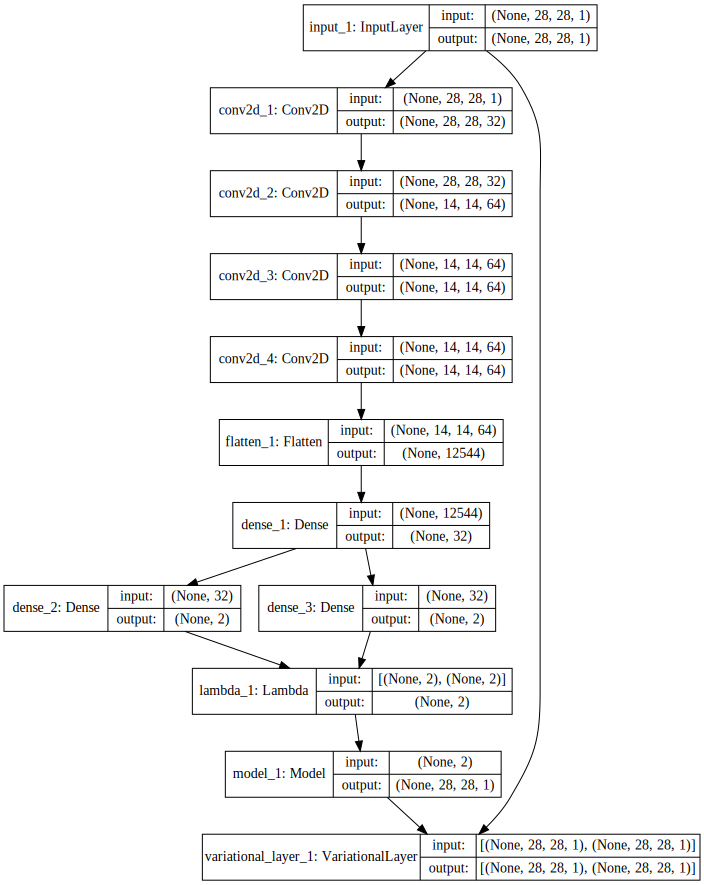

In [7]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [8]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 22s 371us/step - loss: 0.1928 - val_loss: 0.1891
Epoch 2/10
60000/60000 [==============================] - 22s 366us/step - loss: 0.1879 - val_loss: 0.1872
Epoch 3/10
60000/60000 [==============================] - 22s 369us/step - loss: 0.1855 - val_loss: 0.1849
Epoch 4/10
60000/60000 [==============================] - 23s 378us/step - loss: 0.1838 - val_loss: 0.1837
Epoch 5/10
60000/60000 [==============================] - 23s 381us/step - loss: 0.1826 - val_loss: 0.1822
Epoch 6/10
60000/60000 [==============================] - 22s 373us/step - loss: 0.1816 - val_loss: 0.1820
Epoch 7/10
60000/60000 [==============================] - 22s 371us/step - loss: 0.1807 - val_loss: 0.1810
Epoch 8/10
60000/60000 [==============================] - 22s 371us/step - loss: 0.1800 - val_loss: 0.1808
Epoch 9/10
60000/60000 [==============================] - 22s 373us/step - loss: 0.1795 - val_

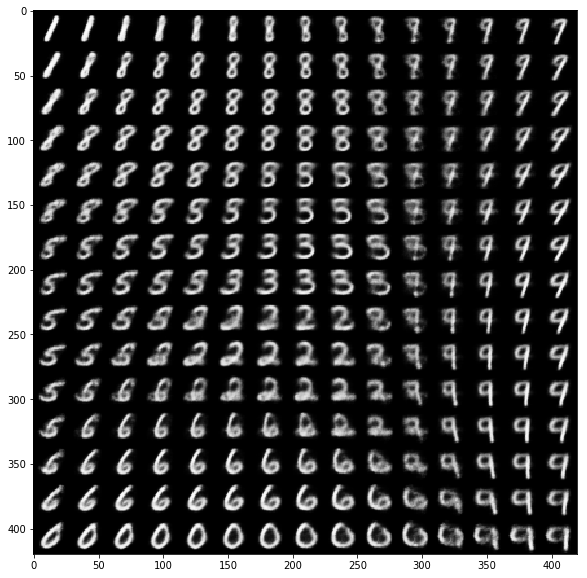

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# You’ll display a grid of 15 × 15 digits (255 digits total).
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Transforms linearly spaced coordinates using the SciPy ppf function 
# to produce values of the latent variable z 
# (because the prior of the latent space is Gaussian)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Repeats z multiple times to form a complete batch
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        # Decodes the batch into digit images        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        # Decodes the batch into digit images
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
